In [1]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

%matplotlib inline
from latent.utils import draw_samples_2d

In [2]:
dataset = Planetoid("data/", "CiteSeer", transform=T.NormalizeFeatures())
dataset.data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [3]:
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327])

In [4]:
data = train_test_split_edges(data)
data

/home/anthony/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3327, 3703], y=[3327], val_pos_edge_index=[2, 227], test_pos_edge_index=[2, 455], train_pos_edge_index=[2, 7740], train_neg_adj_mask=[3327, 3327], val_neg_edge_index=[2, 227], test_neg_edge_index=[2, 455])

In [5]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

In [11]:
from torch_geometric.nn import GAE

# parameters
out_channels = 2
num_features = dataset.num_features

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)



In [13]:
for epoch in range(1, 1000 + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.6087, AP: 0.6611
Epoch: 002, AUC: 0.6346, AP: 0.6868
Epoch: 003, AUC: 0.6388, AP: 0.6922
Epoch: 004, AUC: 0.6406, AP: 0.6962
Epoch: 005, AUC: 0.6442, AP: 0.7027
Epoch: 006, AUC: 0.6491, AP: 0.7092
Epoch: 007, AUC: 0.6504, AP: 0.7105
Epoch: 008, AUC: 0.6508, AP: 0.7110
Epoch: 009, AUC: 0.6523, AP: 0.7131
Epoch: 010, AUC: 0.6549, AP: 0.7164
Epoch: 011, AUC: 0.6573, AP: 0.7197
Epoch: 012, AUC: 0.6593, AP: 0.7227
Epoch: 013, AUC: 0.6608, AP: 0.7255
Epoch: 014, AUC: 0.6622, AP: 0.7287
Epoch: 015, AUC: 0.6639, AP: 0.7312
Epoch: 016, AUC: 0.6646, AP: 0.7334
Epoch: 017, AUC: 0.6654, AP: 0.7356
Epoch: 018, AUC: 0.6656, AP: 0.7367
Epoch: 019, AUC: 0.6658, AP: 0.7377
Epoch: 020, AUC: 0.6663, AP: 0.7385
Epoch: 021, AUC: 0.6667, AP: 0.7390
Epoch: 022, AUC: 0.6670, AP: 0.7392
Epoch: 023, AUC: 0.6673, AP: 0.7395
Epoch: 024, AUC: 0.6679, AP: 0.7400
Epoch: 025, AUC: 0.6686, AP: 0.7404
Epoch: 026, AUC: 0.6695, AP: 0.7406
Epoch: 027, AUC: 0.6713, AP: 0.7412
Epoch: 028, AUC: 0.6747, AP:

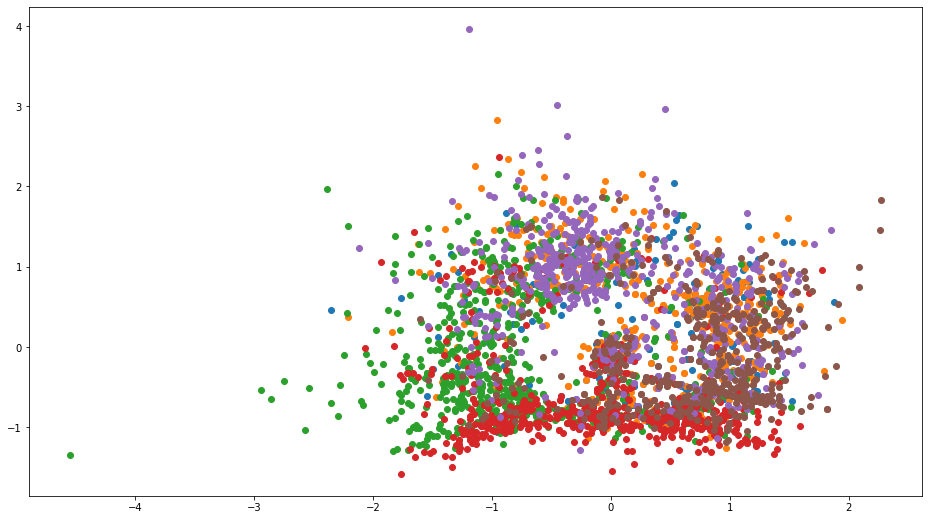

In [14]:
with torch.no_grad():
    Z = model.encode(x, train_pos_edge_index)

draw_samples_2d(Z.cpu().numpy(), data.y)

In [5]:
from torch_geometric.nn import VGAE

dataset = Planetoid("data", "CiteSeer", transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [6]:
out_channels = 2
num_features = dataset.num_features

model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    print(loss)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [10]:
for epoch in range(1, 100 + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

tensor(1.2317, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 001, AUC: 0.6942, AP: 0.7370
tensor(1.2263, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 002, AUC: 0.6986, AP: 0.7397
tensor(1.2220, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 003, AUC: 0.7016, AP: 0.7416
tensor(1.2187, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 004, AUC: 0.7045, AP: 0.7433
tensor(1.2194, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 005, AUC: 0.7077, AP: 0.7455
tensor(1.2144, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 006, AUC: 0.7104, AP: 0.7472
tensor(1.2121, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 007, AUC: 0.7128, AP: 0.7486
tensor(1.2061, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 008, AUC: 0.7147, AP: 0.7498
tensor(1.2012, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 009, AUC: 0.7164, AP: 0.7509
tensor(1.1992, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 010, AUC: 0.7177, AP: 0.7519
tensor(1.1955, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 011, AUC: 0.7195,

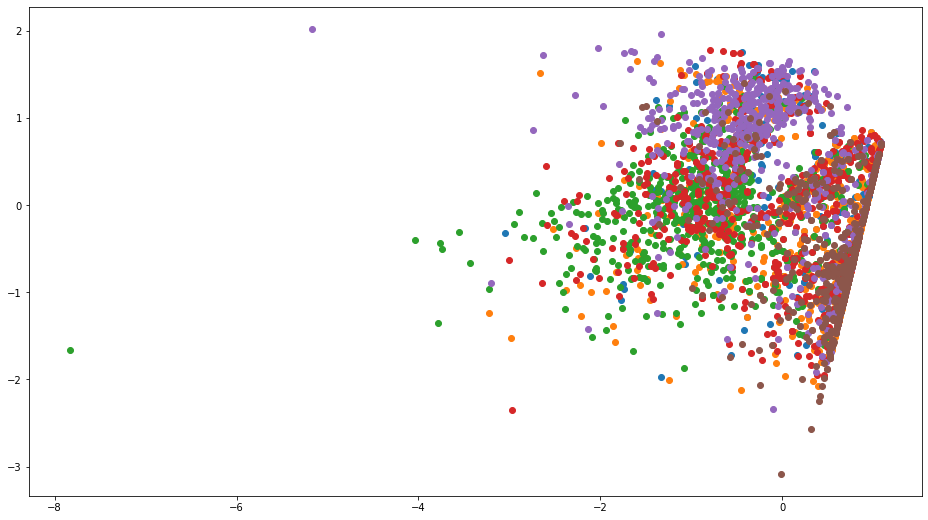

In [39]:
with torch.no_grad():
    Z = model.encode(x, train_pos_edge_index)

draw_samples_2d(Z.cpu().numpy(), data.y)